In [17]:
import sys
sys.path.append('../')
from run import Prepro
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import  GridSearchCV
from utils import utils_tensor as utils #import local functions

In [ ]:
import matplotlib
matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt

In [ ]:
#process vision data to compressed vision data
#pre-specify ranks 
reduced_ranks = [3,5,3,3]

#get vision data: specificify data path here 
x_viz_train = np.load('../data/X_train_vision_1980_34_20_120_w8_at_8.npy',  allow_pickle = True).reshape(-1, steps_in , 9, 25, 25)
x_viz_test = np.load('../data/X_test_vision_1980_34_20_120_w8_at_8.npy', allow_pickle = True).reshape(-1, steps_in, 9, 25, 25)

#crop out some regions 
x_viz_train = x_viz_train[:,:,:,3:20,3:20]
x_viz_test = x_viz_test[:,:,:,3:20,3:20]

#standardize x viz
x_viz_train, x_viz_test = utils.standardize_x_viz(x_viz_train,x_viz_test)

print('compressing vision data for ranks ', reduced_ranks)
#compress vision data
x_viz_train_reduce, compress_error_train = utils.viz_reduce(x_viz_train, reduced_ranks)
x_viz_test_reduce, compress_error_test = utils.viz_reduce(x_viz_test, reduced_ranks)
print('ranks, compression error=',reduced_ranks, compress_error)

#save data: specify data out path and save 
np.save('../data/X_train_vision_comp_1980_34_20_120.npy', x_viz_train_reduce, allow_pickle=True)
np.save('../data/X_test_vision_comp_1980_34_20_120.npy', x_viz_test_reduce, allow_pickle=True)


In [18]:
# load vision and stat data 
window_size=8
predict_at = 8
reduced_ranks = [3,5,3,3]


#load x_viz: pre-processed compressed vision data 
x_viz_train = np.load('../data/X_train_vision_comp_1980_34_20_120.npy', allow_pickle=True)
x_viz_test = np.load('../data/X_test_vision_comp_1980_34_20_120.npy', allow_pickle=True)
#load x_stat: stat_data 
x_stat_train = np.load('../data/X_train_stat_1980_34_20_120_w8_at_8.npy', allow_pickle=True).reshape(-1, window_size, 30)#[:,:,:14]
x_stat_test = np.load('../data/X_test_stat_1980_34_20_120_w8_at_8.npy', allow_pickle=True).reshape(-1, window_size, 30)#[:,:,:14]
#standardize x: 
x_viz_train, x_viz_test = utils.standardize_x_viz(x_viz_train, x_viz_test)
x_stat_train, x_stat_test = utils.standardize_x_stat(x_stat_train, x_stat_test)
#concat viz and stat 
X_train_total = utils.concat_stat_viz(x_stat_train.reshape(-1, 8*30), x_viz_train.reshape(-1, 3*5*3*3))
X_test_total = utils.concat_stat_viz(x_stat_test.reshape(-1, 8*30), x_viz_test.reshape(-1, 3*5*3*3))

#load y: intensity  
tgt_intensity_train = np.load('../data/y_train_intensity_1980_34_20_120_w8_at_8.npy', allow_pickle=True)
tgt_intensity_test = np.load('../data/y_test_intensity_1980_34_20_120_w8_at_8.npy', allow_pickle=True)
#standardize y 
tgt_intensity_train, tgt_intensity_test, mean_, std_  = utils.standardize_y(tgt_intensity_train,tgt_intensity_test)

#load y: displacement 
# tgt_displacement_train = np.load('data/y_train_displacement_1980_50_20_90_w' + str(window_size) + '.npy', allow_pickle=True)
# tgt_displacement_test = np.load('data/y_test_displacement_1980_50_20_90_w' + str(window_size) + '.npy', allow_pickle=True)
#standardize y 
# tgt_dx_train,tgt_dx_test, mean_dx, std_dx  = utils.standardize_y(tgt_displacement_train[:,0],tgt_displacement_test[:,0])
# tgt_dy_train,tgt_dy_test, mean_dy, std_dy  = utils.standardize_y(tgt_displacement_train[:,1],tgt_displacement_test[:,1])

# load y: category  
# tgt_intensity_cat_train = np.load('data/y_train_intensity_cat_1980_50_20_90_w' + str(window_size) + '.npy', allow_pickle=True)
# tgt_intensity_cat_test = np.load('data/y_test_intensity_cat_1980_50_20_90_w' + str(window_size) + '.npy', allow_pickle=True)
# tgt_intensity_cat_baseline_train = np.load('data/y_train_intensity_cat_baseline_1980_50_20_90_w' + str(window_size) + '.npy',  allow_pickle = True)
# tgt_intensity_cat_baseline_test = np.load('data/y_test_intensity_cat_baseline_1980_50_20_90_w' + str(window_size) + '.npy', allow_pickle=True)


In [19]:
tgt_displacement_train = torch.Tensor(np.load('../data/y_train_displacement_1980_34_20_120_w' + str(window_size) + '_at_' + str(predict_at) + '.npy',
                                     allow_pickle=True))
tgt_displacement_test = torch.Tensor(np.load('../data/y_test_displacement_1980_34_20_120_w' + str(window_size) + '_at_' + str(predict_at) + '.npy',
                                    allow_pickle=True))


NameError: name 'torch' is not defined

In [62]:
##feature selection: skit learn has built-in feature selection function, we may not need to use iai. 
# https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/ 
# here is a small example: 
from sklearn.feature_selection import SelectFromModel

#X_train_sparse = X_train.copy()

# fit model on training data
#model = XGBRegressor(max_depth=5, n_estimators=100)
#model.fit(X_train, tgt_intensity_train)

# select features using threshold


xgb2 = XGBRegressor(max_depth=8, n_estimators=140, learning_rate = 0.07, subsample = 0.7, min_child_weight = 5)
xgb2.fit(X_train_total, tgt_intensity_train)
select = SelectFromModel(xgb2, threshold="mean", prefit=True)
X_train_sparse = select.transform(X_train_total)
X_test_sparse = select.transform(X_test_total)
print("MAE intensity: ", mean_absolute_error(np.array(tgt_intensity_test)*std_+mean_, np.array(xgb2.predict(X_test_total))*std_+mean_))



MAE intensity:  7.45447
MAE intensity:  7.5018506


In [53]:
xgb = XGBRegressor(max_depth=8, n_estimators=140, learning_rate = 0.07, subsample = 0.7, min_child_weight = 5)
xgb.fit(X_train_sparse, tgt_intensity_train)
print("MAE intensity: ", mean_absolute_error(np.array(tgt_intensity_test)*std_+mean_, np.array(xgb.predict(X_test_sparse))*std_+mean_))

MAE intensity:  7.5018506


In [50]:
print("MAE intensity: ", mean_absolute_error(np.array(tgt_intensity_test)*std_+mean_, np.array(xgb2.predict(X_test_total))*std_+mean_))

MAE intensity:  7.45447


In [63]:
mybooster = xgb2.get_booster()
model_bytearray = mybooster.save_raw()[4:]
def myfun(self=None):
    return model_bytearray

mybooster.save_raw = myfun

In [59]:
X_train_sparse.shape

(107199, 65)

In [22]:
import shap

In [64]:
explainer = shap.TreeExplainer(mybooster)
shap_values = explainer.shap_values(X_train_total)

In [65]:
shap.initjs()
#shap.force_plot(explainer.expected_value, shap_values[0,:], pd.DataFrame(X_train_sparse).iloc[0,:])
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train_total.iloc[0,:])

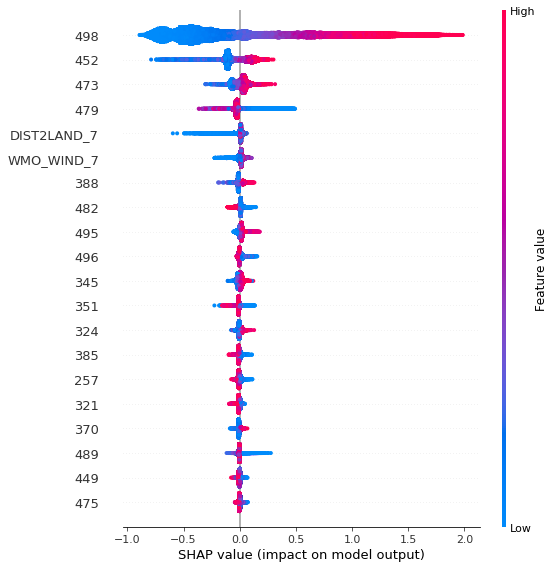

In [66]:
shap.summary_plot(shap_values, X_train_total)

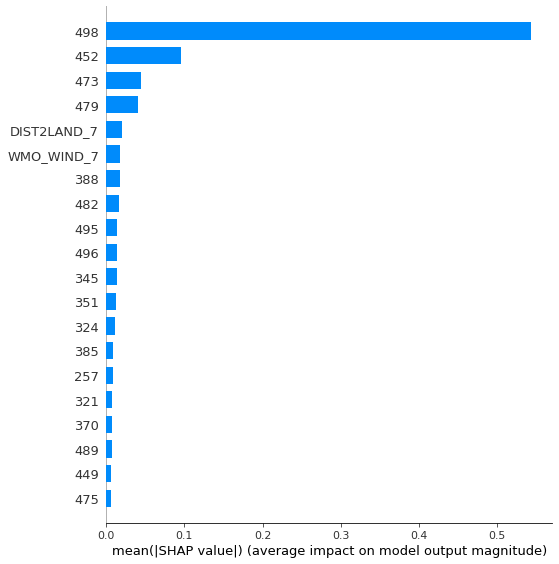

In [67]:
#shap.summary_plot(shap_values, X_train_sparse, plot_type="bar")
shap.summary_plot(shap_values, X_train_total, plot_type="bar")

In [73]:
xgb3 = XGBRegressor(max_depth=6, n_estimators=140, learning_rate = 0.07, subsample = 0.7, min_child_weight = 5)
xgb3.fit(X_train, tgt_intensity_train)
print("MAE intensity: ", mean_absolute_error(np.array(tgt_intensity_test)*std_+mean_, np.array(xgb3.predict(X_test))*std_+mean_))

mybooster = xgb3.get_booster()
model_bytearray = mybooster.save_raw()[4:]
def myfun(self=None):
    return model_bytearray

mybooster.save_raw = myfun

MAE intensity:  7.849733


In [74]:
explainer = shap.TreeExplainer(mybooster)
shap_values = explainer.shap_values(X_train)

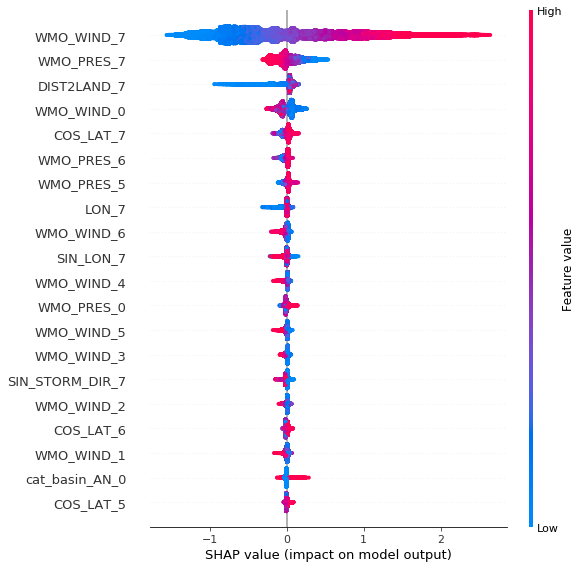

In [75]:
shap.summary_plot(shap_values, X_train)

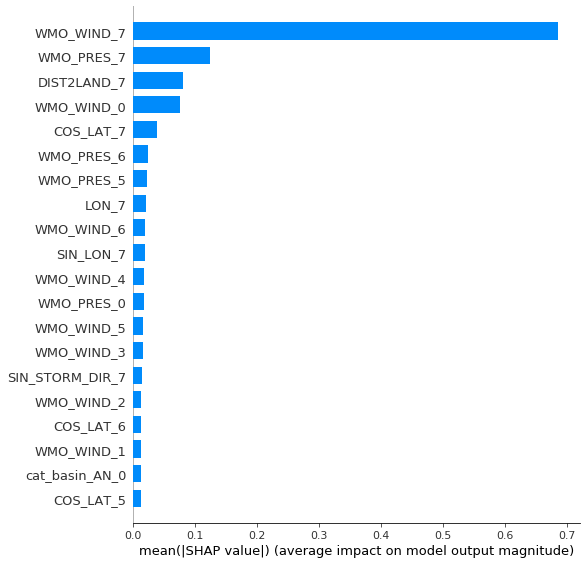

In [76]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [29]:
X_train = np.load('../data/X_train_stat_1980_34_20_120_w' + str(window_size) + '_at_' + str(predict_at) + '.npy',
            allow_pickle=True)
X_test = np.load('../data/X_test_stat_1980_34_20_120_w' + str(window_size) + '_at_' + str(predict_at) + '.npy',
            allow_pickle=True)


names = ['LAT', 'LON', 'WMO_WIND', 'WMO_PRES', 'DIST2LAND',
         'STORM_SPEED', 'cat_cos_day', 'cat_sign_day', 'COS_STORM_DIR', 'SIN_STORM_DIR',
         'COS_LAT', 'SIN_LAT', 'COS_LON', 'SIN_LON', 'cat_storm_category', 'cat_basin_AN',
         'cat_basin_EP', 'cat_basin_NI', 'cat_basin_SA',
         'cat_basin_SI', 'cat_basin_SP', 'cat_basin_WP', 'cat_nature_DS', 'cat_nature_ET',
         'cat_nature_MX', 'cat_nature_NR', 'cat_nature_SS', 'cat_nature_TS',
         'STORM_DISPLACEMENT_X', 'STORM_DISPLACEMENT_Y']

names_all = names * window_size

for i in range(len(names_all)):
    names_all[i] += '_' + str(i // 30)

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
X_train.columns = names_all
X_test.columns = names_all

cols = [c for c in X_train.columns if c.lower()[-2:] == '_0' or c.lower()[:3] != 'cat']

X_train = X_train[cols]
X_test = X_test[cols]

X_test_baseline = pd.DataFrame(np.load('../data/X_test_stat_1980_34_20_120_withforecast_2661_w' + str(window_size) + '_at_' + str(predict_at) + '.npy', allow_pickle=True))

X_test_dates = pd.DataFrame(np.load('../data/X_test_stat_with_dates_columns_1980_w' + str(window_size) + '_at_' + str(predict_at) + '.npy', allow_pickle=True)[:,:4])

X_test_dates.columns = ['YEAR', 'MONTH', 'DAY', 'HOUR']

names_baselines = [#'SID',
         'LAT', 'LON', 'WMO_WIND', 'WMO_PRES', 'DIST2LAND',
         'STORM_SPEED', 'cat_cos_day', 'cat_sign_day', 'COS_STORM_DIR', 'SIN_STORM_DIR',
         'COS_LAT', 'SIN_LAT', 'COS_LON', 'SIN_LON', 'cat_storm_category',
         'EMXI_24_lat', 'EMXI_24_lon', 'EMXI_24_vmax', 'EMXI_24_mslp',
         'SHIP_24_lat', 'SHIP_24_lon', 'SHIP_24_vmax', 'SHIP_24_mslp',
         'AP01_24_lat', 'AP01_24_lon', 'AP01_24_vmax', 'AP01_24_mslp',
         'CMC_24_lat', 'CMC_24_lon', 'CMC_24_vmax', 'CMC_24_mslp',
         'NAM_24_lat', 'NAM_24_lon', 'NAM_24_vmax', 'NAM_24_mslp',
         'HWRF_24_lat', 'HWRF_24_lon', 'HWRF_24_vmax', 'HWRF_24_mslp',
         'cat_basin_AN', 'cat_basin_EP', 'cat_basin_NI', 'cat_basin_SA',
         'cat_basin_SI', 'cat_basin_SP', 'cat_basin_WP',
         #'cat_nature_DS', 'cat_nature_ET',
         #'cat_nature_MX', 'cat_nature_NR', 'cat_nature_SS', 'cat_nature_TS',
         'STORM_DISPLACEMENT_X', 'STORM_DISPLACEMENT_Y']

names_all_baselines = names_baselines * 8#args.window_size

for i in range(len(names_all_baselines)):
    names_all_baselines[i] += '_' + str(i // 48)

X_test_baseline.columns = names_all_baselines

X_test_baseline = pd.concat([X_test_baseline, X_test_dates], axis = 1)

In [42]:
#X_train_embed = np.load('../data/embeddings/X_train_embeds_1980_34_20_120_results8_16_20_44_28.npy', allow_pickle = True)
#X_test_embed = np.load('../data/embeddings/X_test_embeds_1980_34_20_120_results8_16_20_44_28.npy', allow_pickle = True)
X_train_embed = np.load('../data/embeddings/X_train_embed_1980_34_20_120_intensity.npy', allow_pickle = True)
X_test_embed = np.load('../data/embeddings/X_test_embed_1980_34_20_120_intensity.npy', allow_pickle = True)
X_train_total = np.concatenate((X_train, X_train_embed), axis = 1)
X_test_total = np.concatenate((X_test, X_test_embed), axis = 1)

In [43]:
X_train_embed_df = pd.DataFrame(X_train_embed)
X_train_embed_df.cols = ['feature_'+str(i) for i in range(X_train_embed.shape[1])]

In [44]:
X_train_embed_df

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,2.208981e-08,0.413866,-0.000059,-0.000018,-0.981295,-4.383764e-09,-0.000001,4.515641e-10,3.507012e-09,-0.000002,...,-0.000018,4.384447e-09,-0.000036,0.000001,0.000005,0.000077,0.000064,2.189336e-08,-0.000017,0.000004
1,2.238085e-08,0.435908,-0.000062,-0.000018,-0.965977,-1.657099e-09,-0.000001,4.515641e-10,3.443347e-09,-0.000002,...,-0.000018,4.539743e-09,-0.000036,0.000001,0.000005,0.000077,0.000064,2.156412e-08,-0.000017,0.000004
2,2.214801e-08,0.386886,-0.000060,-0.000018,-0.946035,-2.014531e-09,-0.000001,4.179128e-10,3.405148e-09,-0.000002,...,-0.000018,4.886260e-09,-0.000036,0.000001,0.000005,0.000077,0.000063,2.130582e-08,-0.000017,0.000004
3,2.203160e-08,0.331357,-0.000059,-0.000018,-0.934758,-2.157321e-09,-0.000001,3.742571e-10,3.388777e-09,-0.000002,...,-0.000018,5.265065e-09,-0.000036,0.000001,0.000005,0.000077,0.000063,2.091838e-08,-0.000017,0.000004
4,2.223533e-08,0.290027,-0.000061,-0.000018,-0.883135,-2.307488e-12,-0.000001,3.565219e-10,3.337846e-09,-0.000002,...,-0.000018,5.619313e-09,-0.000035,0.000001,0.000005,0.000076,0.000063,2.048728e-08,-0.000017,0.000004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107194,2.204615e-08,0.018863,-0.000047,-0.000018,-0.949406,-2.316483e-09,-0.000001,-5.506990e-10,3.614332e-09,-0.000002,...,-0.000019,-1.405624e-09,-0.000034,0.000001,0.000005,0.000074,0.000064,2.654451e-08,-0.000017,0.000004
107195,2.219167e-08,-0.030403,-0.000048,-0.000018,-0.944454,-1.326953e-09,-0.000001,-5.625225e-10,3.585228e-09,-0.000002,...,-0.000019,-2.090928e-09,-0.000034,0.000001,0.000005,0.000074,0.000064,2.656088e-08,-0.000017,0.000004
107196,2.230809e-08,-0.059834,-0.000049,-0.000018,-0.940943,-2.814886e-10,-0.000001,-5.825314e-10,3.556124e-09,-0.000002,...,-0.000019,-2.692786e-09,-0.000034,0.000001,0.000005,0.000074,0.000064,2.664638e-08,-0.000017,0.000004
107197,2.243905e-08,-0.058389,-0.000051,-0.000018,-0.937447,8.722054e-10,-0.000001,-6.534719e-10,3.530658e-09,-0.000002,...,-0.000019,-3.166861e-09,-0.000034,0.000001,0.000005,0.000074,0.000064,2.653178e-08,-0.000017,0.000004


In [48]:
X_train_total = pd.concat((X_train, pd.DataFrame(X_train_embed_df)), axis = 1)
X_test_total = pd.concat((X_test, pd.DataFrame(X_test_embed)), axis = 1)

In [49]:
X_test_total

,LAT_0,LON_0,WMO_WIND_0,WMO_PRES_0,DIST2LAND_0,STORM_SPEED_0,cat_cos_day_0,cat_sign_day_0,COS_STORM_DIR_0,SIN_STORM_DIR_0,...,502,503,504,505,506,507,508,509,510,511
0,31.600000,-63.200001,55.0,1000.0,1227.0,12.0,0.966848,0.255353,9.702957e-01,0.241922,...,-0.000019,-3.529067e-09,-0.000034,0.000001,0.000005,0.000074,0.000064,2.633533e-08,-0.000017,0.000004
1,32.227200,-63.016701,52.5,1001.5,1216.0,14.0,0.966848,0.255353,9.510565e-01,0.309017,...,-0.000019,-3.473133e-09,-0.000033,0.000001,0.000005,0.000074,0.000065,2.626075e-08,-0.000017,0.000004
2,32.900002,-62.700001,50.0,1003.0,1171.0,15.0,0.966848,0.255353,8.910065e-01,0.453990,...,-0.000019,-3.401055e-09,-0.000033,0.000001,0.000005,0.000074,0.000065,2.619709e-08,-0.000017,0.000004
3,33.542500,-62.209599,47.5,1004.0,1140.0,16.0,0.966848,0.255353,8.191521e-01,0.573576,...,-0.000019,-3.278956e-09,-0.000033,0.000001,0.000005,0.000074,0.000065,2.623347e-08,-0.000017,0.000004
4,12.200000,-133.399994,35.0,1005.0,2428.0,8.0,0.962309,0.271958,-1.908090e-01,-0.981627,...,-0.000017,5.184347e-09,-0.000033,0.000001,0.000005,0.000073,0.000061,2.441629e-08,-0.000017,0.000003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26795,38.667500,-67.214996,40.0,980.0,409.0,2.0,0.929141,0.369725,6.123234e-17,1.000000,...,-0.000018,-5.843049e-09,-0.000035,0.000001,0.000005,0.000076,0.000063,2.625347e-08,-0.000018,0.000004
26796,38.599998,-67.099998,40.0,980.0,423.0,2.0,0.929141,0.369725,-7.313537e-01,0.681998,...,-0.000018,-5.514721e-09,-0.000035,0.000001,0.000005,0.000076,0.000063,2.590241e-08,-0.000018,0.000004
26797,38.522301,-67.037697,40.0,980.0,437.0,3.0,0.929141,0.369725,-7.771460e-01,0.629320,...,-0.000018,-5.483798e-09,-0.000035,0.000001,0.000005,0.000076,0.000063,2.544948e-08,-0.000018,0.000004
26798,38.400002,-66.900002,40.0,980.0,451.0,5.0,0.929141,0.369725,-6.946584e-01,0.719340,...,-0.000018,-5.509946e-09,-0.000035,0.000001,0.000005,0.000076,0.000064,2.503293e-08,-0.000018,0.000004


In [ ]:
train_xgb_intensity(forecast = 'SHIP', basin = 'AN', max_depth=8, n_estimators = 140, learning_rate = 0.07, subsample = 0.7, min_child_weight = 5, forecast2 = 'HWRF')

In [ ]:
##grid search 
grid = GridSearchCV(estimator = XGBRegressor(learning_rate = 0.15, n_estimators=140, max_depth=5,
 min_child_weight=1, subsample=0.8, seed=1),
 param_grid = params, n_jobs=4, scoring = 'neg_mean_absolute_error')

grid.fit(X_train_sparse, tgt_intensity_train)

params = {
 'min_child_weight':range(1,6,2),
 'n_estimators':[100, 140],
 'subsample':[0.6,0.8,1],
 'learning_rate':[0.1, 0.15, 0.2]
}

grid.grid_scores_, grid.best_params_, grid.best_score_